In [1]:
# import required libraries
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Dense

In [2]:
# reading data that is required to be trained on
train_data = 'Fire-Detection'
print(os.listdir(train_data))

['0', '1']


In [3]:
# above we can see that fire dataset is marked as 0(No-fire) and 1(Fire) so seperating data into 2 types
train_fire = os.listdir(os.path.join(train_data, '1'))
train_not_fire = os.listdir(os.path.join(train_data, '0'))

In [4]:
# Setting index to 0 so that every time this cell is runned it will take 8 pictures from each class and print them on screen.
fig_index=0

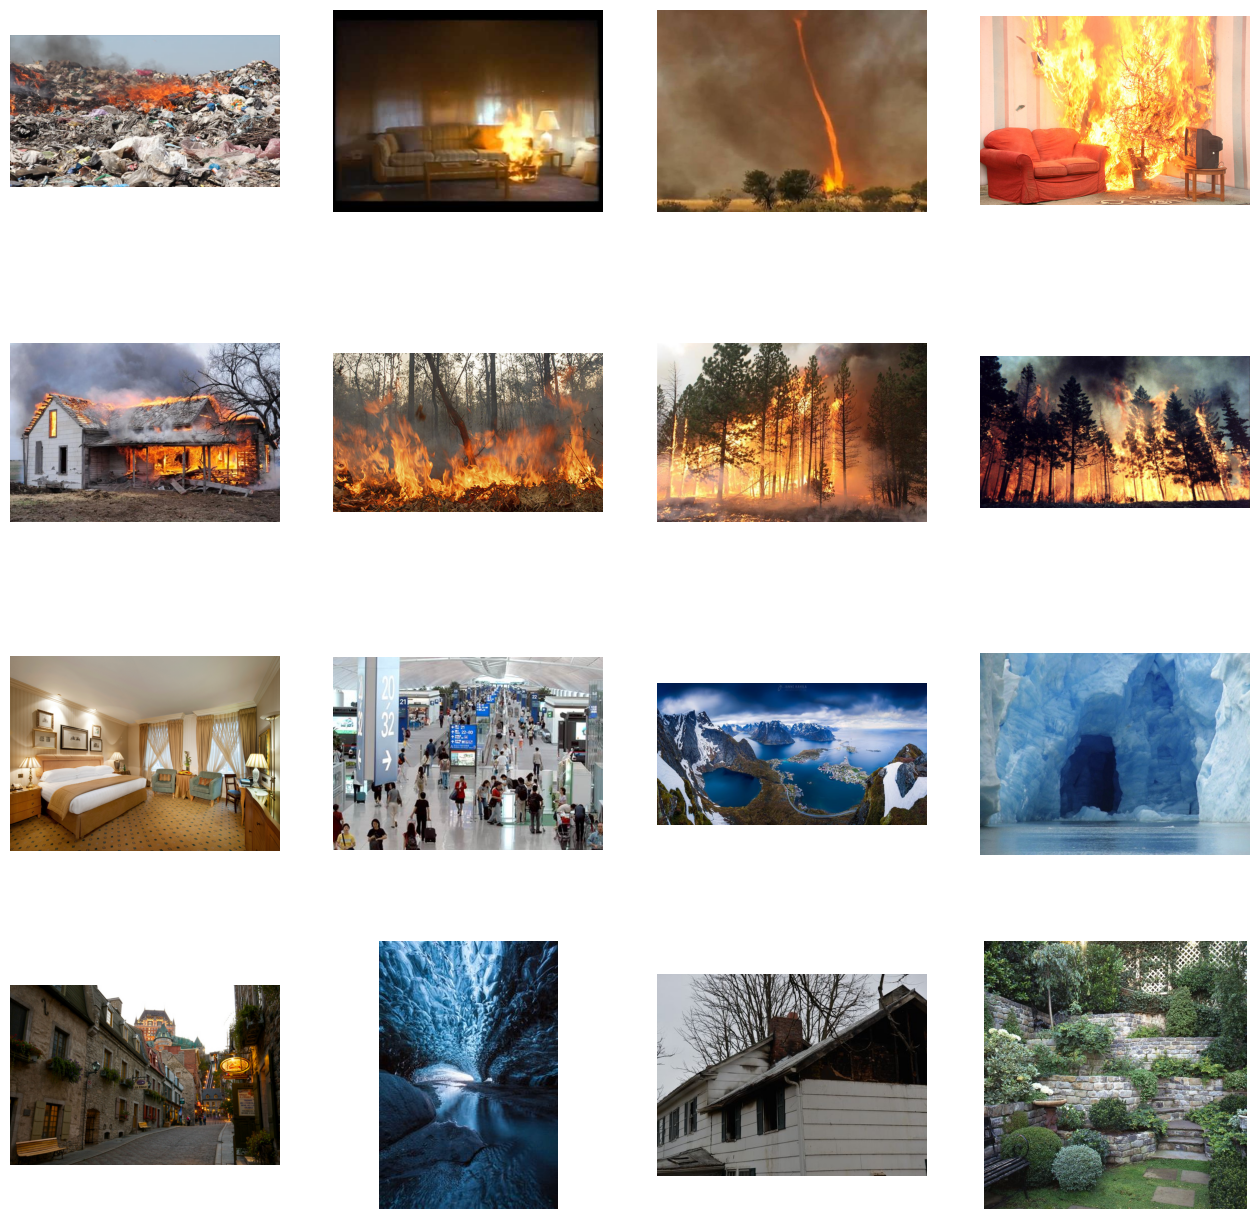

In [5]:
# Setting number of columns and number of rows to view sample images
n_rows = 4
n_cols = 4
# Here we are using gcf to clen the plot if the cell is being runned 2 or more times
fig = plt.gcf()

# Setting the size of each image
fig.set_size_inches(n_rows*4,n_cols*4)

fig_index+=8

# Pulling 8 images from each class to display
fire_8 = [os.path.join(train_data,'1', fname) for fname in train_fire[fig_index-8:fig_index]]
not_fire_8 = [os.path.join(train_data,'0', fname) for fname in train_not_fire[fig_index-8:fig_index]]

# Printing the images from each class, if you notice you will see first 8 images will have fire in them other 8 will not have fire in them
for i,img_path in enumerate(fire_8+not_fire_8):
    sp = plt.subplot(n_rows,n_cols,i+1)
    sp.axis('Off')
    img = mimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [6]:
# Using tensorflow's ImageDataGenerator to prepare the image-data for training
train_gen = ImageDataGenerator(width_shift_range = 0.5,
                              height_shift_range = 0.5,
                              validation_split = 0.2)

train_set = train_gen.flow_from_directory(train_data, target_size = (300, 300), class_mode = 'binary', subset = 'training', batch_size = 8)

validation_set = train_gen.flow_from_directory(train_data, target_size = (300, 300), class_mode = 'binary', subset = 'validation', batch_size = 8)

Found 521 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [7]:
# Using pre-trained Resnet-50 layers model to train on our fire-dataset
# here we are setting include_top as False, as we will add our own dense layers after resnet 50 last layer
pre_trained_resnet_50 = tf.keras.applications.ResNet50(include_top = False,
                                                      input_shape = (300,300,3),
                                                      pooling = 'avg',
                                                      classes = 100,
                                                      weights = 'imagenet')

x = 0
for layer in pre_trained_resnet_50.layers:
    layer.trainable = False
    x+=1
    if x == 39:
        break

In [8]:
# Adding extra Dense layers after Resnet 50 last layer, we do this to increase our models capability to categorise image as having fire or not having fire
model = Sequential()
model.add(pre_trained_resnet_50)
model.add(Dense(2048,activation='relu'))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4000,activation='relu'))
model.add(Dense(2000,activation='relu'))
model.add(Dense(1000,activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(250,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 4096)              8392704   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 8000)              32776000  
                                                                 
 dropout_1 (Dropout)         (None, 8000)              0         
                                                                 
 dense_3 (Dense)             (None, 4000)              3

In [9]:
# Using tensorflow's learning-rate-scheduler to change learning rate at each epoch, this will help us to find the best learning rate for our model 
callback_lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

# Using tensorflow's Model-Checkpoint to save best model having less validation loss
modelcheck_lr = tf.keras.callbacks.ModelCheckpoint(filepath='final_model.h5', monitor='val_loss', save_best_only = True)

# Using Adam's optimizer to optimize our model to better learn on our dataset
model.compile(optimizer = tf.keras.optimizers.Adam() ,loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
# Now time to train our model on fire dataset
model_hist = model.fit(train_set, validation_data = validation_set, epochs = 100, callbacks = [callback_lr, modelcheck_lr])

In [ ]:
# Creating graph to visualzie how our model performed at different learning rate and its loss.
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, model_hist.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 1])